In [1]:
import math as m
import numpy as np
import random as r
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
import torch
from torch import nn
from torch import optim

In [3]:
from nflows.flows.base import Flow
from nflows.distributions.uniform import BoxUniform
from nflows.transforms.base import CompositeTransform
from nflows.transforms.autoregressive import MaskedPiecewiseRationalQuadraticAutoregressiveTransform
from nflows.transforms.permutations import RandomPermutation
from nflows.transforms.splines.rational_quadratic import rational_quadratic_spline
from nflows.transforms.dequantization import UniformDequantization
from nflows.transforms.dequantization import VariationalDequantization

In [4]:
# Import data and weights
x_data = torch.tensor(pd.read_csv("data.csv", header=None, delimiter=",").to_numpy(), dtype=torch.float32)
x_weights = torch.tensor(pd.read_csv("weights.csv", header=None, delimiter=",").to_numpy(), dtype=torch.float32).squeeze()

# Normalize weights by mean
x_weights /= x_weights.mean()

# Permute the data
permutation = torch.randperm(x_data.shape[0])
x_data = x_data[permutation]
x_weights = x_weights[permutation]

In [5]:
# Determine the maximum labels of discrete dims
max_features = torch.max(x_data, dim=0)[0]
is_discrete = max_features > 1
max_labels = torch.where(max_features > 1, max_features, torch.tensor(-1.))

In [6]:
num_layers = 5
base_dist_uniform = BoxUniform(torch.zeros(4), torch.ones(4))
base_dist_variational = BoxUniform(torch.zeros(4), torch.ones(4))

transforms_uniform = []
transforms_variational = []

transforms_uniform.append(UniformDequantization(max_labels=max_labels))
transforms_variational.append(VariationalDequantization(max_labels=max_labels, rqs_hidden_features=15, rqs_flow_layers=2))

for _ in range(num_layers):
    transforms_uniform.append(RandomPermutation(features=4))
    transforms_uniform.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=4, 
        hidden_features=25,
        num_bins=5,
        num_blocks=4,
    ))

    transforms_variational.append(RandomPermutation(features=4))
    transforms_variational.append(MaskedPiecewiseRationalQuadraticAutoregressiveTransform(
        features=4, 
        hidden_features=25,
        num_bins=5,
        num_blocks=4,
    ))

transform_uniform = CompositeTransform(transforms_uniform)
transform_variational = CompositeTransform(transforms_variational)

flow_uniform = Flow(transform_uniform, base_dist_uniform)
flow_variational = Flow(transform_variational, base_dist_variational)

optimizer_uniform = optim.Adam(flow_uniform.parameters())
optimizer_variational = optim.Adam(flow_variational.parameters())

In [7]:
n_epochs = 10
batch_size = 500
n_batches = m.ceil(x_data.shape[0]/batch_size)

for epoch in range(n_epochs):
    permutation = torch.randperm(x_data.shape[0])    

    # Loop over batches
    cum_loss_uniform = 0
    cum_loss_variational = 0
    for batch in range(n_batches):
        # Set up the batch
        batch_begin = batch*batch_size
        batch_end   = min( (batch+1)*batch_size, x_data.shape[0]-1 )
        indices = permutation[batch_begin:batch_end]
        x_data_batch = x_data[indices]
        x_weights_batch = x_weights[indices]
        
        # Take a step
        optimizer_uniform.zero_grad()
        optimizer_variational.zero_grad()

        loss_uniform = -(flow_uniform.log_prob(inputs=x_data_batch)*x_weights_batch).mean()
        loss_variational = -(flow_variational.log_prob(inputs=x_data_batch)*x_weights_batch).mean()

        loss_uniform.backward()
        loss_variational.backward()

        optimizer_uniform.step()
        optimizer_variational.step()

        # Compute cumulative loss
        cum_loss_uniform = (cum_loss_uniform*batch + loss_uniform.item())/(batch+1)
        cum_loss_variational = (cum_loss_variational*batch + loss_variational.item())/(batch+1)

        print("epoch = ", epoch, "batch = ",batch+1, "/", n_batches, "loss_uniform = ", cum_loss_uniform, " loss_variational = ", cum_loss_variational)

 loss_uniform =  -7.381687297768499  loss_variational =  -7.429567298941704
epoch =  9 batch =  1816 / 2001 loss_uniform =  -7.381449998737955  loss_variational =  -7.429362243492698
epoch =  9 batch =  1817 / 2001 loss_uniform =  -7.3816573085795385  loss_variational =  -7.429602981204178
epoch =  9 batch =  1818 / 2001 loss_uniform =  -7.381153934728455  loss_variational =  -7.429094781183173
epoch =  9 batch =  1819 / 2001 loss_uniform =  -7.381289366511867  loss_variational =  -7.429195122249576
epoch =  9 batch =  1820 / 2001 loss_uniform =  -7.381869681588894  loss_variational =  -7.42974511895861
epoch =  9 batch =  1821 / 2001 loss_uniform =  -7.3824353516592796  loss_variational =  -7.430314011393111
epoch =  9 batch =  1822 / 2001 loss_uniform =  -7.3833048699585175  loss_variational =  -7.431184136645069
epoch =  9 batch =  1823 / 2001 loss_uniform =  -7.383096377665172  loss_variational =  -7.430943758750576
epoch =  9 batch =  1824 / 2001 loss_uniform =  -7.384100006076325

In [8]:
n_sample = 1000000
with torch.no_grad():
    x_uniform = flow_uniform.sample(n_sample)
    x_variational = flow_variational.sample(n_sample)

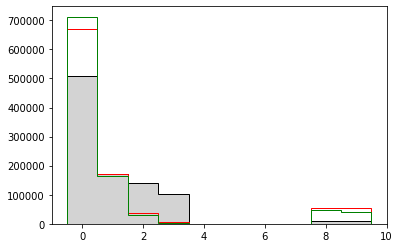

In [9]:
plt.hist(x_data.detach().numpy()[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins=np.linspace(-0.5, 9.5, 11))
plt.hist(x_uniform[:,2], edgecolor="red", histtype="step", bins = np.linspace(-0.5, 9.5, 11))
plt.hist(x_variational[:,2], edgecolor="green", histtype="step", bins = np.linspace(-0.5, 9.5, 11))
plt.show()

In [10]:
with torch.no_grad():
    x_uniform_dequantized, _ = flow_uniform._transform._transforms[0].forward(x_data)
    x_variational_dequantized, _ = flow_variational._transform._transforms[0].forward(x_data)

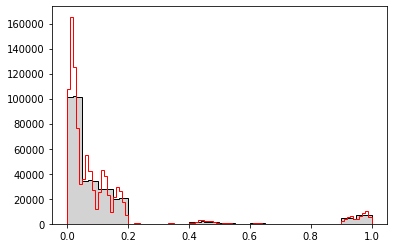

In [11]:
plt.hist(x_uniform_dequantized[:,2], histtype='stepfilled', edgecolor="black", facecolor="lightgray", bins = 100)
plt.hist(x_variational_dequantized[:,2], edgecolor="red", histtype="step", bins = 100)
plt.show()